### Tim Keriazes

#### Aug 18, 2022

# Lending Club Loan Default Prediction Project Utilizing Classification Modeling Zillow Data Set

#### Scenario

#### Project Description:
##### Financial institutions across the globe have a need to accurately parse which customers are appropriate candidates for their financial offerings. Based on a customer's historical financials, institutions aqcuire the ability to accurately assess risk and make appropriate business decisions. In this project, I will analyze the lending_club_loan_two.csv dataset to discover drivers for loan defaults. I will use my discoveries to build a machine learning model that would help predict the status of a customer's loan, and in turn, whether or not they are likely candidates to default on a loan.

Project Planning/Outline:
1. Investigating the dataset/data dictionary
2. Establishing initial questions/hypotheses
3. Data acquisition
4. Data preparation
5. Exploration and Data Analysis
6. Identify drivers
7. Encode features
8. Split data
9. Model
10. Evaluate Models
11. Test
12. Conclusions/Next Steps 

#### Hypothesis
1. Loan status is correlated with sub_grade
2. Loan status is correlated with revol_util
3. Loan status is correlated with int_rate

### Target variable
#### loan_status (Charged Off or Fully Paid)

Key Findings
1. 80% of the observations were fully paid, so if we predict all of the observations are fully paid, baseline would predict correctly 80% of the time, establishing a baseline accuracy of 80%
2. high loan amount, high installment, looks like it has more charge offs
3. high int rate, looks like high charge offs
4. high loan amount for renters looks like higher charge offs
5. high int rate, high dti, higher charge offs
6. low subgrade/grade, looks like higher charge offs


### Best model = Random Forest with depth of 15

##### Imports

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas
import wrangle_lending as wr

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import warnings
warnings.filterwarnings('ignore')

### Read in data aqcuired from Kaggle
- https://www.kaggle.com/datasets/jeandedieunyandwi/lending-club-dataset

In [3]:
data = pd.read_csv("lending_club_loan_two.csv")
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-15,Fully Paid,vacation,Vacation,26.24,Jun-90,16,0,36369,41.80,25,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-15,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-04,17,0,20131,53.30,27,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-15,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-07,13,0,11987,92.20,26,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-14,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-06,6,0,5472,21.50,13,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-13,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-99,13,0,24584,69.80,43,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
df = data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  int64  
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

### Cleanup Summary
    - drop columns of emp_title, emp_length, title
    - drop rows with null values in col revol_util, pub_rec_bankruptcies
    - impute nulls with value of 2 in mort_acc feature based on boxplot/distplots
    -create and utilize clean_lending() function

In [10]:
#validate
df = wr.clean_lending(df)
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

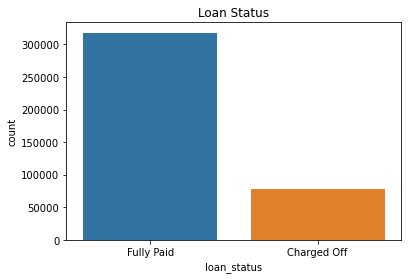

In [11]:
#count of target variable
sns.countplot(data=df, x='loan_status', )
plt.title("Loan Status")
plt.ylabel("count")
plt.show() 

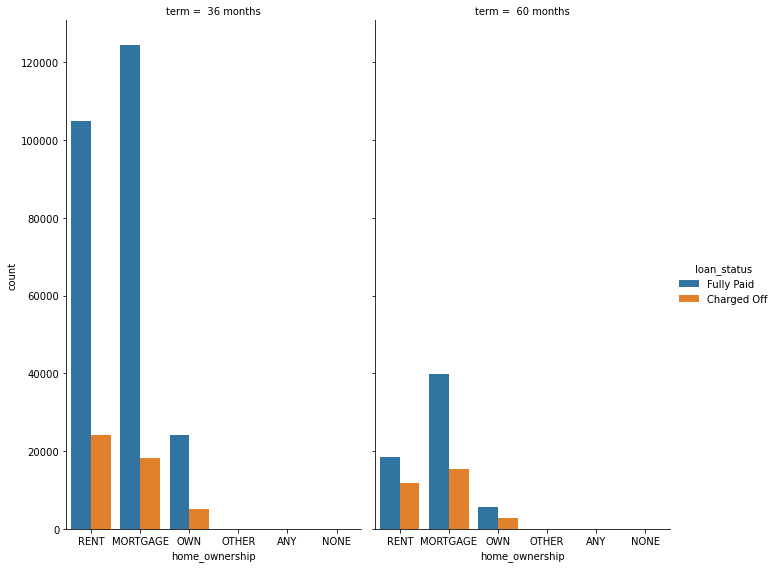

In [12]:
g = sns.catplot(x="home_ownership", hue="loan_status", col="term",
                data=df, kind="count",
                height=8, aspect=.6);

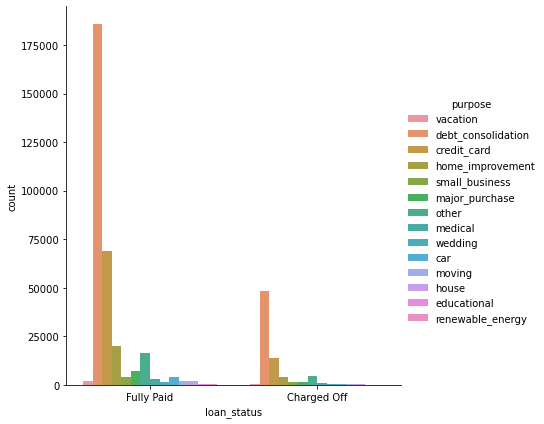

In [13]:
g = sns.catplot(x="loan_status", hue="purpose",
                data=df, kind="count",
                height=6, aspect=1);

<AxesSubplot:xlabel='loan_status', ylabel='annual_inc'>

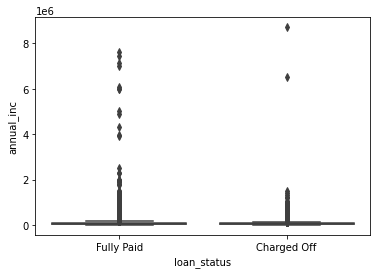

In [14]:
sns.boxplot(x='loan_status', y='annual_inc', data=df)

<AxesSubplot:xlabel='loan_status', ylabel='dti'>

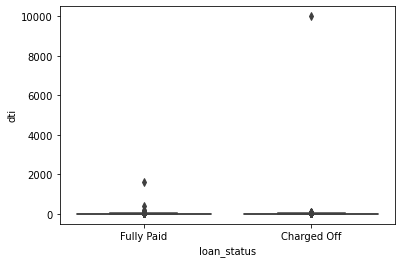

In [15]:
sns.boxplot(x='loan_status', y='dti', data=df)

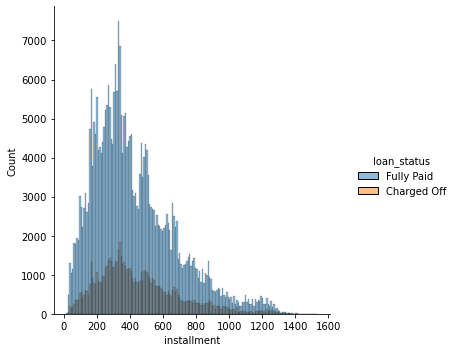

In [16]:
sns.displot(data=df, x='installment', hue='loan_status')

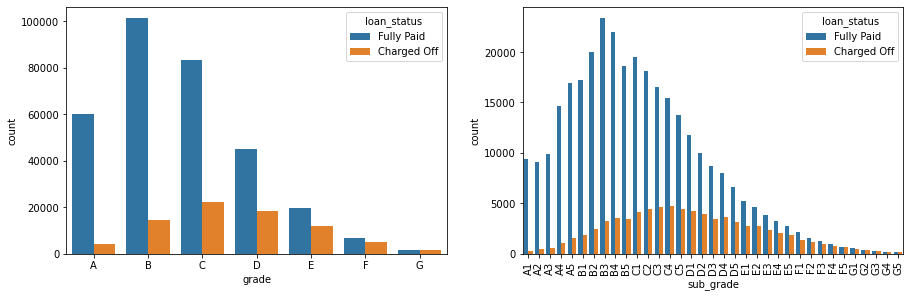

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

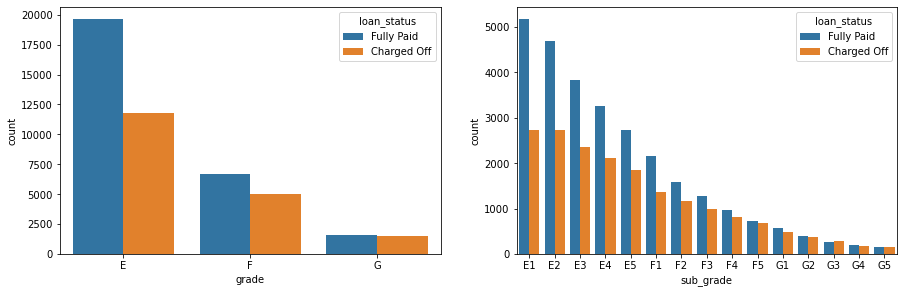

In [18]:
c = df[(df.grade == 'E')| (df.grade == 'F')| (df.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(c.grade.unique().tolist())
sns.countplot(x='grade', data=c, hue='loan_status',hue_order=['Fully Paid','Charged Off'], order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(c.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=c, hue='loan_status',hue_order=['Fully Paid','Charged Off'], order=sub_grade)

In [19]:
df.loc[df.dti >= 40, 'loan_status'].value_counts()

Fully Paid     200
Charged Off     96
Name: loan_status, dtype: int64

In [20]:
df.loc[df.annual_inc >= 1000000, 'loan_status'].value_counts()

Fully Paid     64
Charged Off    10
Name: loan_status, dtype: int64

In [21]:
df.loc[df.annual_inc <= 250000, 'loan_status'].value_counts()

Fully Paid     314849
Charged Off     77085
Name: loan_status, dtype: int64

### EDA Outlier Analysis
- get rid of dti > 40
- get rid of total_acc > 115
- get rid of annual_inc > 250,000
- get rid of revol_util > 200
- get rid of pub_rec > 25
- get rid of open_acc > 60
- get rid of small proportion of home_ownership values for ['OTHER','ANY','NONE']



In [22]:
df =wr.remove_outliers(df)

<AxesSubplot:>

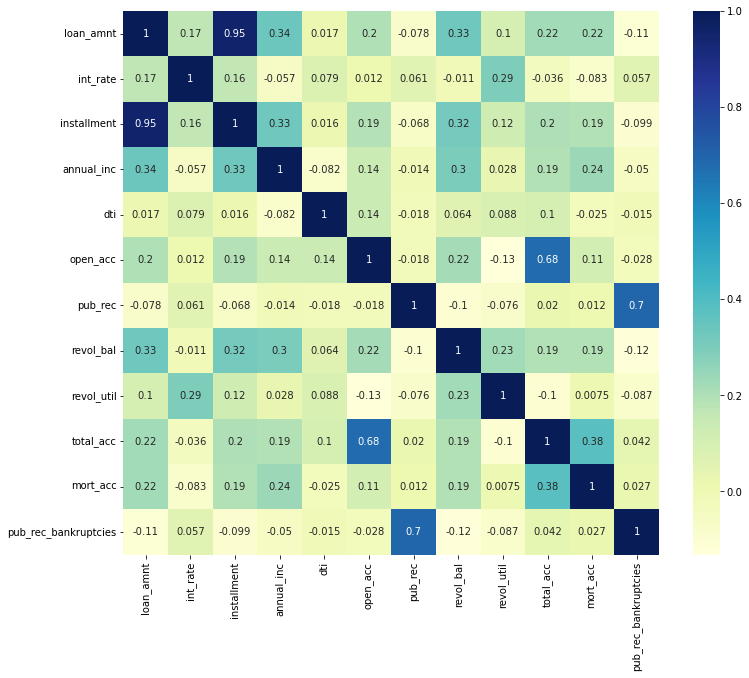

In [23]:
#examining the correllation between the features
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')

#### Heatmap takeaways:
- loan amount and installment are appear to be highly correlated
- loan amount and revol balance appear to be correlated 
- loan amount and annual income appear to be correlated
- annual income and installment appear to be correlated

### Split Data

In [24]:
train, validate, test = wr.split_data(df)

In [25]:
train.shape, validate.shape, test.shape

((219229, 24), (93956, 24), (78297, 24))

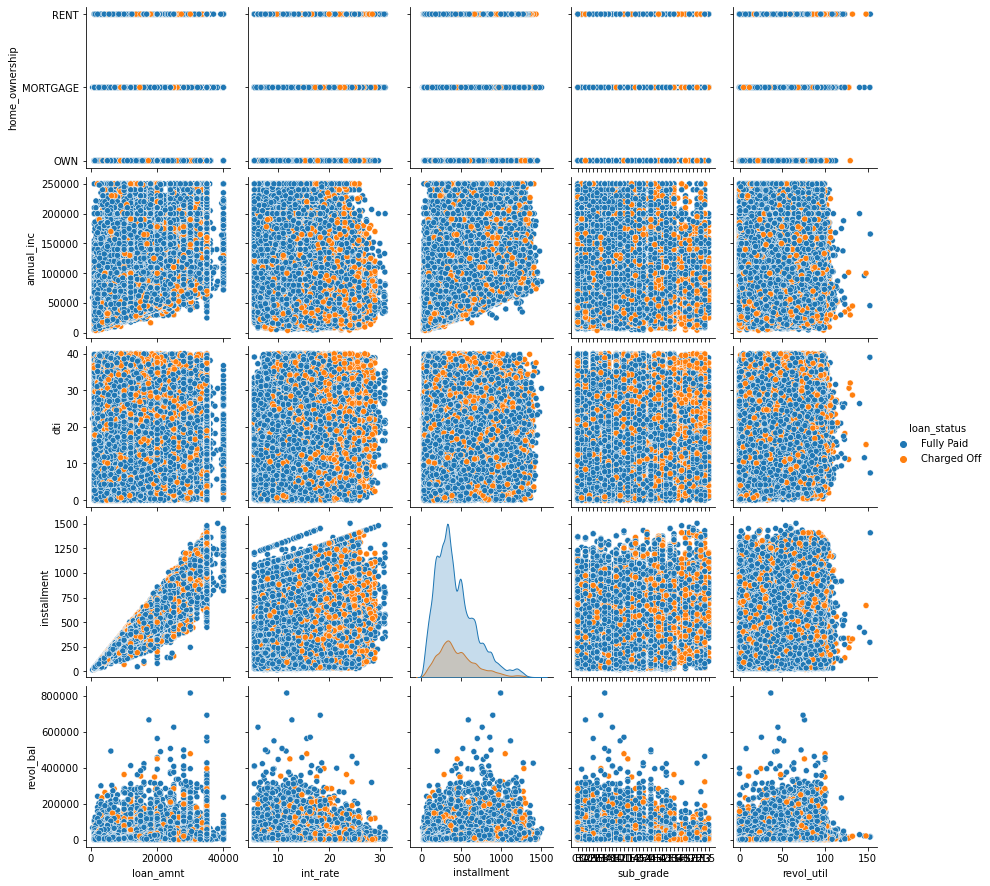

In [26]:
sns.pairplot(data=train, hue='loan_status', x_vars=['loan_amnt', 'int_rate', 'installment', 'sub_grade','revol_util'],y_vars=['home_ownership', 'annual_inc','dti', 'installment','revol_bal'  ])

#### additional takeaways
- high loan amount, high installment, looks like it has more charge offs
- high int rate, looks like high charge offs
- high loan amount for renters looks like higher charge offs
- high int rate, high dti, higher charge offs
- low subgrade/grade, looks like higher charge offs

#### Identify features based on EDA that appear to be predictors for loan default
- categoricals:['grade','home_ownership','verification_status','initial_list_status']
- numericals:['loan_amnt','int_rate','installment','annual_inc','dti','mort_acc']

#### Encode Categoricals

#### Look at Decision Tree

In [28]:
#encode functions from wrangle_lending
train, validate, test = wr.encode_features(train, validate, test)

In [29]:
train.shape,validate.shape,test.shape

((219229, 28), (93956, 28), (78297, 28))

In [32]:
train, validate, test =wr.drop_columns(train, validate, test)

In [33]:
train.shape, validate.shape, test.shape

((219229, 13), (93956, 13), (78297, 13))

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219229 entries, 332679 to 363879
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               219229 non-null  int64  
 1   int_rate                219229 non-null  float64
 2   installment             219229 non-null  float64
 3   annual_inc              219229 non-null  float64
 4   loan_status             219229 non-null  object 
 5   dti                     219229 non-null  float64
 6   revol_bal               219229 non-null  int64  
 7   revol_util              219229 non-null  float64
 8   mort_acc                219229 non-null  float64
 9   home_ownership_encoded  219229 non-null  int64  
 10  w                       219229 non-null  uint8  
 11  Source Verified         219229 non-null  uint8  
 12  Verified                219229 non-null  uint8  
dtypes: float64(6), int64(3), object(1), uint8(3)
memory usage: 19.0+ MB


### Modeling

- establish baseline
- fit models on train sets only
- 80% of the observations were fully paid, so if we predict all of the observations are fully paid, baseline would predict correctly 80% of the time, establishing a baseline accuracy of 80%

In [ ]:
#baseline
train.loan_status.value_counts(normalize=True)

- Define X and Y based on my refined features
- remove target variable (loan_status) and set as Y

In [35]:
X_train = train.drop(columns=['loan_status'])
y_train = train.loan_status

X_validate = validate.drop(columns=['loan_status'])
y_validate = validate.loan_status

X_test = test.drop(columns=['loan_status'])
y_test = test.loan_status

### Create Random Forest Model

In [37]:
rf = RandomForestClassifier(max_depth=15, random_state=123)

#### Fit the model

In [38]:
rf = rf.fit(X_train, y_train)
rf

RandomForestClassifier(max_depth=15, random_state=123)

In [39]:
# visualize the importance weight
feature_importances = pd.DataFrame(rf.feature_importances_,
                                  index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
int_rate,0.24
dti,0.14
revol_bal,0.11
installment,0.11
revol_util,0.11
annual_inc,0.11
loan_amnt,0.09
mort_acc,0.04
home_ownership_encoded,0.02
w,0.01


#### Make Predictions

In [40]:
#make predictions
y_pred = rf.predict(X_train)
# estimate probability:
y_pred_proba = rf.predict_proba(X_train)

#### Compute Accuracy

In [41]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.84


#### Confusion Matrix

In [42]:
print(confusion_matrix(y_train, y_pred))

[[  7922  35176]
 [   149 175982]]


In [43]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,Charged Off,Fully Paid
Charged Off,7922,35176
Fully Paid,149,175982


#### Classification Report

Precision: 
TP/(TP+FP)

Recall:
TP/(TP+FN)

F1-Score: A measure of accuracy. The harmonic mean of precision & recall. The harmonic mean is the reciprocal of the arithmetic mean of the reciprocals.

F1 ∈[0,1]

F1-score = harmonic mean = 2/(1/precision)+(1/recall)

Support: number of occurrences of each class.

In [44]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.98      0.18      0.31     43098
  Fully Paid       0.83      1.00      0.91    176131

    accuracy                           0.84    219229
   macro avg       0.91      0.59      0.61    219229
weighted avg       0.86      0.84      0.79    219229



#### After concluding trials, starting with depth of 3 yielding precision of 0% for Charged Off, increasing to depth of 15, increased to 84% accuracy, 98% precision on Charged Off for Train

### Model with Validate set

In [45]:
#compute accuracy
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.81


In [46]:
#make predictions
y_pred = rf.predict(X_validate)
# estimate probability:
y_pred_proba = rf.predict_proba(X_validate)

In [47]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.55      0.05      0.09     18470
  Fully Paid       0.81      0.99      0.89     75486

    accuracy                           0.81     93956
   macro avg       0.68      0.52      0.49     93956
weighted avg       0.76      0.81      0.73     93956



### Validate did not have quite as good as performance, 81% accuracy

### Model Testing
-Random Forest depth 15 on test set

In [48]:
#compute accuracy
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.80


In [49]:
#make predictions
y_pred = rf.predict(X_test)
# estimate probability:
y_pred_proba = rf.predict_proba(X_test)

In [50]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.54      0.05      0.08     15392
  Fully Paid       0.81      0.99      0.89     62905

    accuracy                           0.80     78297
   macro avg       0.68      0.52      0.49     78297
weighted avg       0.76      0.80      0.73     78297



## Summary
### Following the evaluation of the different models using my selected features, I found that the best performing model was the Random Forest with depth 15

### Looks like the models performance does much better as the the depth increases at the expense of processing power.

### Next Steps: I would recommend doing some cost-benefit analysis on how this model can be used. At larger depth values, the model's precision for the 'Charged Off' values increases dramatically, but at the cost of some additional misclassification of customers into the false positive and false negative realm. With some additional time I think I could reexamine the features I utilized and incorporate a more refined list of values and include some scaling for a regression model.